In [1]:
%cd ..

/home/proste/mff/evgena


In [2]:
import os
import glob
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from evgena.dataset import Dataset
from evgena.model import TrainableTfModel
from evgena.data_transformations import decode_labels, images_to_BHWC

Using TensorFlow backend.


## Dataset visualization ##

In [57]:
dataset_name = 'fashion_mnist'
dataset = Dataset.from_nprecord('datasets/{}.npz'.format(dataset_name))

In [53]:
is_gray = dataset.train.X.ndim == 3
im_w, im_h = dataset.train.X.shape[1:3]
pad = 4
layout = np.array([[i] * 8 + [i+1] * 8 for i in range(0, 10, 2)])
la_h, la_w = layout.shape

canvas = np.ones(
    shape=(
        la_h * (im_h + pad) - pad,
        la_w * (im_w + pad) - pad
    ) + () if is_gray else (dataset.train.X.shape[3],),
    dtype=np.float32
)

for la_r in range(la_h):
    for la_c in range(la_w):
        t, l = la_r * (im_h + pad), la_c * (im_w + pad)
        b, r = t + im_h, l + im_w
        
        if is_gray:
            canvas[t:b, l:r] = 1 - dataset.train.X[dataset.train.y == layout[la_r, la_c]][la_r * la_w + la_c]
        else:
            canvas[t:b, l:r] = dataset.train.X[dataset.train.y == layout[la_r, la_c]][la_r * la_w + la_c]

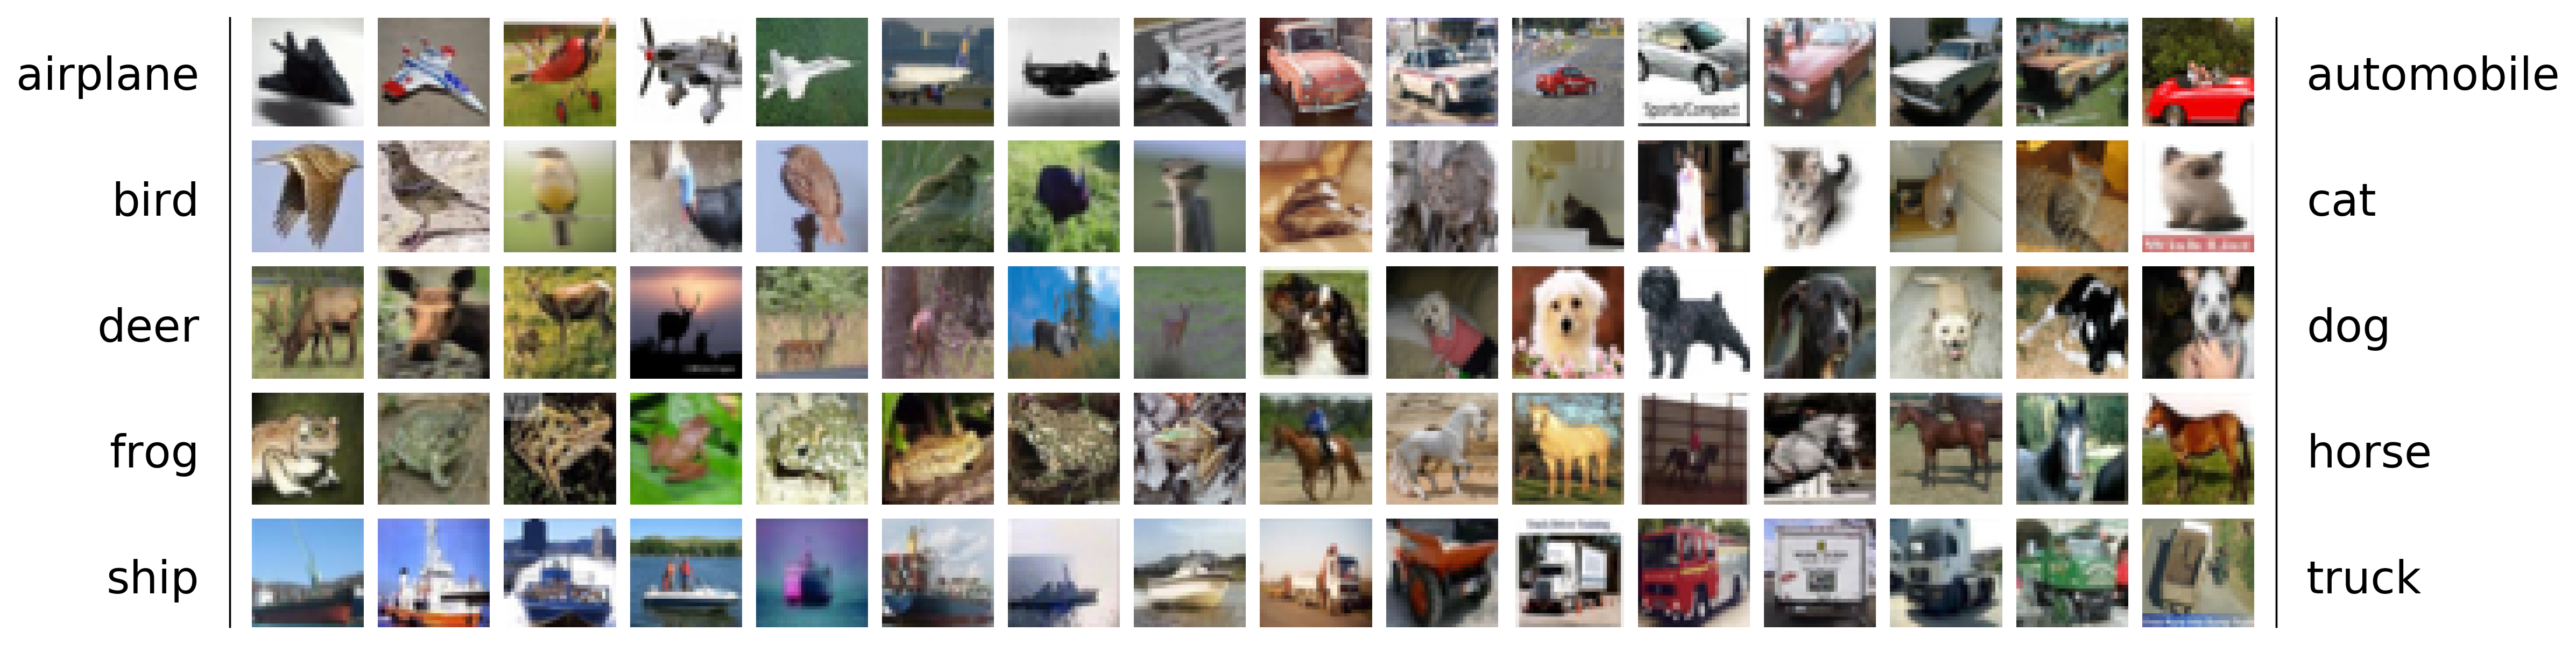

In [54]:
fig = plt.figure(figsize=(la_w, la_h), dpi=300, frameon=False)
label_size = 20
pad_length = 10
even_ax = plt.gca()
odd_ax = even_ax.twinx()

if is_gray:
    even_ax.imshow(canvas, cmap='gray')
    odd_ax.imshow(canvas, cmap='gray')

else:
    even_ax.imshow(canvas)
    odd_ax.imshow(canvas)

even_ax.patch.set_visible(False)
even_ax.set_yticks(np.arange(la_h) * (im_h + pad) + im_h // 2)
even_ax.set_yticklabels(dataset.metadata['synset'][np.arange(la_h) * 2])
even_ax.tick_params(labelsize=label_size, left=False, pad=pad_length)
even_ax.xaxis.set_visible(False)
odd_ax.patch.set_visible(False)
odd_ax.set_yticks(np.arange(la_h) * (im_h + pad) + im_h // 2)
odd_ax.set_yticklabels(dataset.metadata['synset'][np.arange(la_h) * 2 + 1])
odd_ax.tick_params(labelsize=label_size, right=False, pad=pad_length)
odd_ax.xaxis.set_visible(False)
sns.despine(fig, right=False, bottom=True, offset=10)

fig.savefig('thesis/img/{}.pdf'.format(dataset_name), dpi=300, format='pdf', bbox_inches='tight')

## Adversarial example visualization ##

In [231]:
dataset = Dataset.from_nprecord('datasets/stratified_fashion_mnist.npz')
simplenet = TrainableTfModel('models/fashion_mnist_simplenet/fold_7/')
densenet = TrainableTfModel('models/fashion_mnist_densenet/fold_0/')

INFO:tensorflow:Restoring parameters from models/fashion_mnist_simplenet/fold_7/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_0/last


In [283]:
with np.load(
    'experiments/fgsm/direct/simplenet/single/fgsm_direct_simplenet_single_targeted_3_fold_0.npz'
) as direct_f:
    direct_targeted_dress = direct_f['adv_ex']

with np.load(
    'experiments/fgsm/full_surrogate/simplenet/single/simplenet/simplenet_simplenet_0_fgsm_full_surrogate_single_targeted_3.npz'
) as full_f:
    full_targeted_dress = full_f['adv_ex']

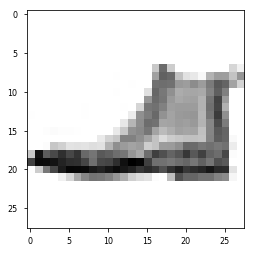

In [281]:
plt.imshow(1 - dataset.test.X[dataset.test.y == 9][12], cmap='gray')

In [261]:
direct_targeted_dress.shape

(9000, 28, 28, 1)

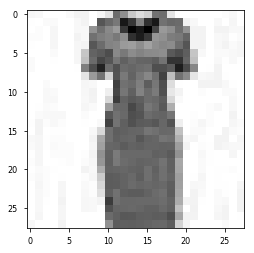

In [253]:
plt.imshow(1 - full_non_targeted[dataset.test.y == 3][29][:, :, 0], cmap='gray')

In [284]:
np.save(
    'thesis/img/simplenet_ankle_boot_12.npy',
    np.stack((
        dataset.test.X[dataset.test.y == 9][12],
        direct_non_targeted[dataset.test.y == 9][12][:, :, 0],
        full_non_targeted[dataset.test.y == 9][12][:, :, 0],
        np.load('experiments/ea/simplenet_ankle_boot_12.npy')
    ))
)

In [243]:
non_targeted_simplenet.shape

(112, 28)

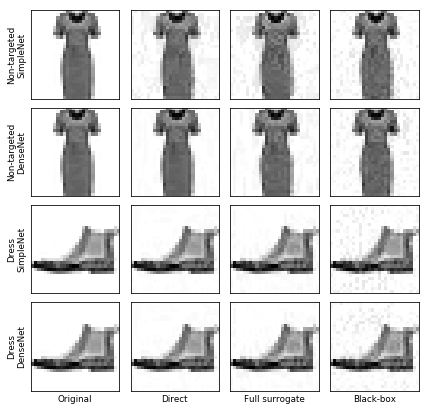

In [296]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7,7))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for axis in [axis for axes_row in axes for axis in axes_row]:
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

non_targeted_simplenet = np.load('thesis/img/simplenet_dress_29.npy')
axes[0, 0].yaxis.set_label_text('Non-targeted\nSimpleNet')
axes[0, 0].imshow(1 - non_targeted_simplenet[0], cmap='gray')
#axes[0, 0].xaxis.set_label_text('Original')
axes[0, 1].imshow(1 - non_targeted_simplenet[1], cmap='gray')
#axes[0, 1].xaxis.set_label_text('Direct')
axes[0, 2].imshow(1 - non_targeted_simplenet[2], cmap='gray')
#axes[0, 2].xaxis.set_label_text('Full surrogate')
axes[0, 3].imshow(1 - non_targeted_simplenet[3], cmap='gray')
#axes[0, 3].xaxis.set_label_text('Black-box')

non_targeted_densenet = np.load('thesis/img/densenet_dress_29.npy')
axes[1, 0].yaxis.set_label_text('Non-targeted\nDenseNet')
axes[1, 0].imshow(1 - non_targeted_densenet[0], cmap='gray')
axes[1, 1].imshow(1 - non_targeted_densenet[1], cmap='gray')
axes[1, 2].imshow(1 - non_targeted_densenet[2], cmap='gray')
axes[1, 3].imshow(1 - non_targeted_densenet[3], cmap='gray')

targeted_simplenet = np.load('thesis/img/simplenet_ankle_boot_12.npy')
axes[2, 0].yaxis.set_label_text('Dress\nSimpleNet')
axes[2, 0].imshow(1 - targeted_simplenet[0], cmap='gray')
axes[2, 1].imshow(1 - targeted_simplenet[1], cmap='gray')
axes[2, 2].imshow(1 - targeted_simplenet[2], cmap='gray')
axes[2, 3].imshow(1 - targeted_simplenet[3], cmap='gray')

targeted_densenet = np.load('thesis/img/densenet_ankle_boot_12.npy')
axes[3, 0].yaxis.set_label_text('Dress\nDenseNet')
axes[3, 0].imshow(1 - targeted_densenet[0], cmap='gray')
axes[3, 0].xaxis.set_label_text('Original')
axes[3, 1].imshow(1 - targeted_densenet[1], cmap='gray')
axes[3, 1].xaxis.set_label_text('Direct')
axes[3, 2].imshow(1 - targeted_densenet[2], cmap='gray')
axes[3, 2].xaxis.set_label_text('Full surrogate')
axes[3, 3].imshow(1 - targeted_densenet[3], cmap='gray')
axes[3, 3].xaxis.set_label_text('Black-box')

fig.savefig('thesis/img/advex_vis.pdf'.format(dataset_name), dpi=300, format='pdf', bbox_inches='tight')

## Model visualization ##

In [20]:
dataset = Dataset.from_nprecord('datasets/stratified_fashion_mnist.npz')

In [21]:
results = {}
for architecture in ['densenet', 'simplenet']:
    results[architecture] = []
    for model in (TrainableTfModel('models/fashion_mnist_{}/fold_{}'.format(architecture, i)) for i in range(10)):
        results[architecture].append(model.evaluate())

INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_0/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_0/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_1/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_1/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_2/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_2/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_3/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_3/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_4/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_4/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_5/last
INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold

In [22]:
densenet = pd.DataFrame(data={k: v for k, v in zip(['acc', 'loss'], tuple(zip(*results['densenet']))[:2])})
densenet['architecture'] = 'densenet'
simplenet = pd.DataFrame(data={k: v for k, v in zip(['acc', 'loss'], tuple(zip(*results['simplenet']))[:2])})
simplenet['architecture'] = 'simplenet'
metrics = pd.concat((densenet, simplenet))

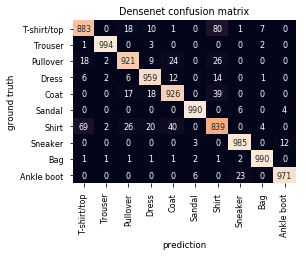

In [23]:
architecture = 'densenet'
fold = 0

plt.gcf().set_size_inches(4, 3)
cm = results[architecture][fold][-1]
heatmap = pd.DataFrame(data=cm.absolute, index=dataset.metadata['synset'], columns=dataset.metadata['synset'])
heatmap.index.rename('ground truth', inplace=True)
heatmap.columns.rename('prediction', inplace=True)

sns.set_context('paper')
g = sns.heatmap(
    data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False, 
    annot_kws={'size': 8}, annot=True
)
g.set_title(architecture.capitalize() + ' confusion matrix')
exp_name = '{}_cm'.format(architecture)

plt.gcf().savefig(
    'thesis/img/{}.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

In [25]:
np.argsort(heatmap.values[:3])

array([[1, 5, 9, 4, 7, 8, 3, 2, 6, 0],
       [2, 4, 5, 6, 7, 9, 0, 8, 3, 1],
       [5, 7, 8, 9, 1, 3, 0, 4, 6, 2]])

In [30]:
dataset.metadata['synset'][np.argsort(heatmap.values[:, 3])]

array(['Sandal', 'Sneaker', 'Ankle boot', 'Bag', 'Trouser', 'Pullover',
       'T-shirt/top', 'Coat', 'Shirt', 'Dress'], dtype='<U11')

In [113]:
np.flip(dataset.metadata['synset'][np.argsort(heatmap.values.diagonal())], axis=0)

array(['Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot', 'Dress',
       'Coat', 'Pullover', 'T-shirt/top', 'Shirt'], dtype='<U11')

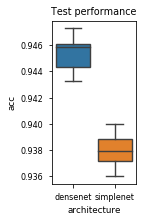

In [82]:
plt.gcf().set_size_inches(1.5, 3)
g = sns.boxplot(data=metrics, y='acc', x='architecture')
g.set_title('Test performance')
exp_name = 'models_test'

plt.gcf().savefig(
    'thesis/img/{}.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

/home/proste/mff/evgena/env_evgena/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


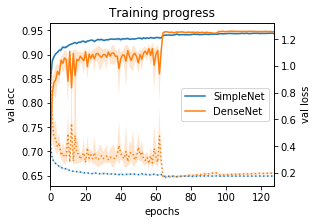

In [3]:
result = {}
for model_type, metric in [(t, m) for t in ['simplenet', 'densenet'] for m in ['loss', 'acc']]:
    metrics = []
    for f_i in range(10):
        with open(
            'experiments/fashion_mnist_{}_fold_{}_val_{}.csv'.format(model_type, f_i, metric), 'r'
        ) as loss_f:
            metrics.append(np.array([float(line.rstrip().split(',')[-1]) for l_i, line in enumerate(loss_f) if l_i != 0]))
    
    metrics = np.array(metrics)
    result['_'.join((model_type, metric))] = metrics
    
fig, ax = plt.subplots(figsize=(4,3))
ax2 = ax.twinx()
cp = sns.color_palette()
sns.tsplot(
    condition=['SimpleNet', 'DenseNet'], legend=True, ax=ax, value='val acc',
    data=np.stack((result['simplenet_acc'], result['densenet_acc']), axis=-1), ci=95)
sns.tsplot(
    condition=['SimpleNet', 'DenseNet'], legend=False, linestyle=':', ax=ax2, value='val loss',
    data=np.stack((result['simplenet_loss'], result['densenet_loss']), axis=-1), ci=95)

ax.legend(loc='center right')
ax.set_xlabel('epochs')
ax.set_title('Training progress')

fig.savefig('thesis/img/training.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [83]:
densenet = TrainableTfModel('models/fashion_mnist_densenet/fold_0')

INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_0/last


In [87]:
simplenet = TrainableTfModel('models/fashion_mnist_simplenet/fold_0')

INFO:tensorflow:Restoring parameters from models/fashion_mnist_simplenet/fold_0/last


In [86]:
sum([np.product(var.shape.as_list()) for var in densenet._session.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])

119578

In [88]:
sum([np.product(var.shape.as_list()) for var in simplenet._session.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])

897130

## FGSM steps visualization ##

In [3]:
dataset = Dataset.from_nprecord('datasets/stratified_fashion_mnist.npz')

In [14]:
algos = ['fgsm_white', 'fgsm_plain_surrogate', 'fgsm_full_surrogate']
architectures = ['simplenet', 'densenet']
targets = ['targeted_{}'.format(i) for i in range(10)] + ['non_targeted']
scope = ['single', 'universal']

In [5]:
def data_path(
    target_architecture, source_architecture,
    target, approach, case, scope, fold
):
    return 'experiments/' + '_'.join((architecture, str(fold), approach, case, scope, target)) + '.npz'

In [6]:
# approach (fgsm, ea, hybrid)
# case (fgsm: direct, plain_surrogate, full_surrogate, reduced_surrogate, binary_surrogate; ea: direct; hybrid: full_surrogate, binary_surrogate)
# target_architecture ('simplenet', 'densenet') (scores correspond to it)
# surrogate_architecture ('simplenet', 'densenet')
# target (non-targeted, 0-9)
# scope (single, universal)
# fold_[0-10]

In [ ]:
# white box fgsm
    # success rate (as confusion matrix)
    # architecture comparison
    # class comparison (with respect to confusion matrix)

In [190]:
# surrogate
    # plain vs full vs reduced (success rate)
    # 

In [ ]:
# ga
    # median class (classification performance / fgsm performance)

In [4]:
def experiment_to_df(dir_name, target, test, use_cached=True):
    df_path = os.path.join(dir_name, target + '.csv')
    
    if os.path.isfile(df_path) and use_cached:
        return pd.read_csv(df_path)
    
    fold_paths = glob.glob(os.path.join(dir_name, '*{}*.npz'.format(target)))
    
    if target != 'non_targeted':
        test = test[test.y != int(target[-1])]
    
    step_counts = []
    mses = []
    for path in fold_paths:
        with np.load(path) as exp_f:
            adv_ex, step_count = [
                exp_f[key] for key in ['adv_ex', 'step_count']
            ]
            
            step_counts.append(step_count)
            mses.append(np.mean(255 * np.abs(adv_ex - images_to_BHWC(test.X)), axis=(1, 2, 3)))
    
    step_counts = np.array(step_counts)
    mses = np.array(mses)
    
    mask = (step_counts == -1).sum(axis=0) < (step_counts.shape[0] / 2)
    
    df = pd.DataFrame(
        data={
            'label': test.y[mask],
            'steps': np.median(step_counts[:, mask], axis=0),
            'mse': np.median(mses[:, mask], axis=0),
        },
        index=test.id[mask]
    )
    df.to_csv(df_path)
    
    return df

### Full FGSM ###

In [38]:
dir_name = 'experiments/fgsm/direct/{surrogate}/single'
# dir_name = 'experiments/fgsm/full_surrogate/reduced_{same}/single/{surrogate}'

plt.gcf().set_size_inches(4, 3)
for target in ['non_targeted'] + ['targeted_{}'.format(i) for i in range(10)]:
    densenet = experiment_to_df(
        dir_name.format(same='densenet', diff='simplenet', surrogate='densenet'), target, dataset.test
    )
    simplenet = experiment_to_df(
        dir_name.format(same='simplenet', diff='densenet', surrogate='simplenet'), target, dataset.test
    )

    densenet['architecture'] = 'densenet'
    simplenet['architecture'] = 'simplenet'

    df = pd.concat((densenet, simplenet))
    df['label'] = dataset.metadata['synset'][df['label']]

    sns.set_context('paper')
    
    if target == 'targeted_3':
        order = [
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
        ]
    else:
        order = [
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
        ]
    
    g = sns.boxplot(order=order, data=df, x='label', y='steps', hue='architecture', showfliers=False, linewidth=1)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.legend(loc='upper center')
    
    if target == 'non_targeted':
        g.set_title('Non targeted')
    else:
        g.set_title(dataset.metadata['synset'][int(target[-1])])


    exp_name = dir_name.format(same='same', diff='diff', surrogate=target).replace('/', '_')
    plt.gcf().savefig(
        'thesis/img/{}.pdf'.format(exp_name),
        dpi=300, format='pdf', bbox_inches='tight'
    )
    plt.clf()

### Targeted confusion matrix ###

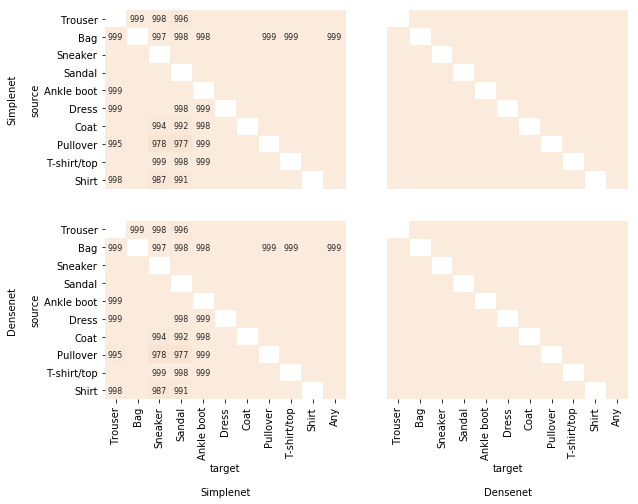

In [5]:
# dir_name = 'experiments/fgsm/plain_surrogate/{tt}/single/{st}'
dir_name = 'experiments/fgsm/direct/{tt}/single'

plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.tight_layout()
for row_i, surrogate_architecture in enumerate(['simplenet', 'densenet']):
    for col_i, target_architecture in enumerate(['simplenet', 'densenet']):
        dfs = []
        for target in chain.from_iterable((['targeted_{}'.format(i) for i in range(10)], ['non_targeted'])):
            df = experiment_to_df(dir_name.format(tt=target_architecture, st=surrogate_architecture), target, dataset.test, use_cached=True)
            df['target'] = target
            dfs.append(df)

        df = pd.concat(dfs)

        heatmap = df.pivot_table(
            values='steps', index='label', columns='target', aggfunc=len, fill_value=0
        )
        heatmap = heatmap.rename(
            index={i: dataset.metadata['synset'][i] for i in range(10)},
            columns={**{'targeted_{}'.format(i): dataset.metadata['synset'][i] for i in range(10)}, **{'non_targeted': 'Any'}}
        )

        heatmap = heatmap[[
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'] + ['Any']]
        heatmap = heatmap.reindex(index=[
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
        ], fill_value=0)
        heatmap.index.rename('source', inplace=True)

        mask = np.zeros(shape=(10, 11), dtype=np.bool)
        np.fill_diagonal(mask, True)
        sns.set_context('paper')
        g = sns.heatmap(
            ax=ax[row_i, col_i],
            data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False,
            annot=np.where(heatmap.values == 1000, '', heatmap),
            annot_kws={'size': 8}, mask=mask,
            xticklabels='auto' if row_i == 1 else False,
            yticklabels='auto' if col_i == 0 else False,
        )
        
        if col_i == 0:
            g.yaxis.set_label_text('{}\n\nsource'.format(['Simplenet', 'Densenet'][row_i]))
        else:
            g.yaxis.set_visible(False)
        
        if row_i == 1:
            g.xaxis.set_label_text('target\n\n{}'.format(['Simplenet', 'Densenet'][col_i]))
        else:
            g.xaxis.set_visible(False)

exp_name = dir_name.format(tt='', st='').replace('/', '_')

plt.gcf().savefig(
    'thesis/img/{}_cm.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

In [9]:
dir_name = 'experiments/fgsm/direct/{tt}/single'


plt.gcf().set_size_inches(4, 3)

for target_architecture in ['simplenet', 'densenet']:
    dfs = []
    for target in chain.from_iterable((['targeted_{}'.format(i) for i in range(10)], ['non_targeted'])):
        df = experiment_to_df(dir_name.format(tt=target_architecture), target, dataset.test, use_cached=True)
        df['target'] = target
        dfs.append(df)

    df = pd.concat(dfs)

    heatmap = df.pivot_table(
        values='steps', index='label', columns='target', aggfunc=len, fill_value=0
    )
    heatmap = heatmap.rename(
        index={i: dataset.metadata['synset'][i] for i in range(10)},
        columns={**{'targeted_{}'.format(i): dataset.metadata['synset'][i] for i in range(10)}, **{'non_targeted': 'Any'}}
    )

    heatmap = heatmap[[
        'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
        'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'] + ['Any']]
    heatmap = heatmap.reindex(index=[
        'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
        'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
    ], fill_value=0)
    heatmap.index.rename('source', inplace=True)

    mask = np.zeros(shape=(10, 11), dtype=np.bool)
    np.fill_diagonal(mask, True)
    sns.set_context('paper')
    g = sns.heatmap(
        data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False,
        annot=np.where(heatmap.values == 1000, '', heatmap),
        annot_kws={'size': 8}, mask=mask,
    )

    exp_name = dir_name.format(tt=target_architecture).replace('/', '_')

    plt.gcf().savefig(
        'thesis/img/{}_cm.pdf'.format(exp_name),
        dpi=300, format='pdf', bbox_inches='tight'
    )
    plt.clf()

### Binary FGSM ###

In [8]:
use_cached = False
target_class = 3
dir_name = 'experiments/fgsm/binary_surrogate/densenet/single/{surrogate}'

plt.gcf().set_size_inches(4, 3)
for target in ['non_targeted', 'targeted_{}'.format(target_class)]:
    densenet = experiment_to_df(
        dir_name.format(same='densenet', diff='simplenet', surrogate='densenet'), target,
        dataset.test[(dataset.test.y == target_class) if (target == 'non_targeted') else (dataset.test.y != target_class)],
        use_cached=use_cached
    )
    simplenet = experiment_to_df(
        dir_name.format(same='simplenet', diff='densenet', surrogate='simplenet'), target,
        dataset.test[(dataset.test.y == target_class) if (target == 'non_targeted') else (dataset.test.y != target_class)],
        use_cached=use_cached
    )

    densenet['architecture'] = 'densenet'
    simplenet['architecture'] = 'simplenet'

    df = pd.concat((densenet, simplenet))
    df['label'] = dataset.metadata['synset'][df['label']]

    sns.set_context('paper')
    g = sns.boxplot(data=df, x='label', y='steps', hue='architecture', showfliers=False, linewidth=1)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.legend(loc='upper center')
    
    if target == 'non_targeted':
        g.set_title('Non targeted')
    else:
        g.set_title(dataset.metadata['synset'][int(target[-1])])


    exp_name = dir_name.format(same='same', diff='diff', surrogate=target).replace('/', '_')
    plt.gcf().savefig(
        'thesis/img/{}.pdf'.format(exp_name),
        dpi=300, format='pdf', bbox_inches='tight'
    )
    plt.clf()

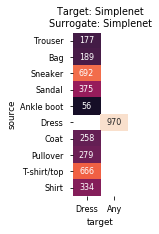

In [162]:
target_class = 3
dir_name = 'experiments/fgsm/binary_surrogate/{tt}/single/{st}'

surrogate_architecture = 'simplenet'
target_architecture = 'simplenet'

plt.gcf().set_size_inches(1, 3)
dfs = []
for target in ['targeted_{}'.format(target_class), 'non_targeted']:
    df = experiment_to_df(
        dir_name.format(tt=target_architecture, st=surrogate_architecture), target,
        dataset.test[(dataset.test.y == target_class) if (target == 'non_targeted') else (dataset.test.y != target_class)],
        use_cached=False
    )
    df['target'] = target
    dfs.append(df)

df = pd.concat(dfs)

heatmap = df.pivot_table(
    values='steps', index='label', columns='target', aggfunc=len, fill_value=0
)
heatmap = heatmap.rename(
    index={i: dataset.metadata['synset'][i] for i in range(10)},
    columns={**{'targeted_{}'.format(i): dataset.metadata['synset'][i] for i in range(10)}, **{'non_targeted': 'Any'}}
)

heatmap = heatmap[[dataset.metadata['synset'][target_class], 'Any']]
heatmap = heatmap.reindex(index=[
    'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
    'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
], fill_value=0)
heatmap.index.rename('source', inplace=True)

mask = np.zeros(shape=(10, 2), dtype=np.bool)
mask[5, 0] = True
mask[:, 1] = True
mask[5, 1] = False
sns.set_context('paper')
g = sns.heatmap(
    data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False,
    annot=np.where(heatmap.values == 1000, '', heatmap),
    annot_kws={'size': 8}, mask=mask
)
g.set_title('Target: {tt}\nSurrogate: {st}'.format(
    st=surrogate_architecture.capitalize(),
    tt=target_architecture.capitalize()
))

exp_name = dir_name.format(tt=target_architecture, st=surrogate_architecture).replace('/', '_')

plt.gcf().savefig(
    'thesis/img/{}_cm.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

### Pure EA ###

In [89]:
targeted_results.dtype

dtype((numpy.record, [('step_count', '<i4'), ('noise', '<f4', (28, 28)), ('objectives', '<f4', (2,))]))

In [96]:
model = TrainableTfModel('models/fashion_mnist_densenet/fold_0/')

INFO:tensorflow:Restoring parameters from models/fashion_mnist_densenet/fold_0/last


[[1.4376484e-01 3.0322733e-06 5.9036069e-05 8.3935988e-01 7.7423806e-07
  7.9625906e-06 1.6781026e-02 3.9177903e-06 1.7421145e-05 2.0765913e-06]]


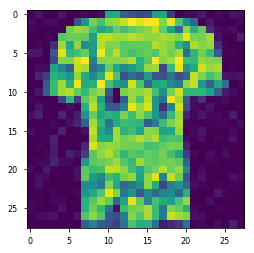

In [106]:
label = 0
i = 6
ex = np.clip(dataset.test.X[dataset.test.y == label][targeted_indices[label][i]] + targeted_results.noise[label*300 + i], 0, 1)
print(model(ex))
_ = plt.imshow(ex)

In [126]:
import json

In [127]:
dataset = Dataset.from_nprecord('datasets/stratified_fashion_mnist.npz')

In [128]:
with open('experiments/ea/targeted_indices.json', 'r') as target_f:
    targeted_indices = json.load(target_f)
    targeted_indices.insert(3, None)

with open('experiments/ea/all_non_targeted_indices.json', 'r') as non_target_f:
    non_targeted_indices = json.load(non_target_f)

In [49]:
with open('experiments/ea/targeted_indices.json', 'r') as target_f:
    targeted_indices = json.load(target_f)
    targeted_indices.insert(3, None)

with open('experiments/ea/non_targeted_indices.json', 'r') as non_target_f:
    non_targeted_indices = json.load(non_target_f)

In [198]:
target_class = 3

dfs = []
# for architecture in ['simplenet', 'densenet']:
for architecture in ['densenet', 'simplenet']:
    targeted_results = np.load(
        'experiments/ea/{}_results.npy'.format(architecture)
    ).view(np.recarray)
    non_targeted_results = np.load(
        'experiments/ea/full_{}_non_targeted_results.npy'.format(architecture)
    ).view(np.recarray)
    # non_targeted_results = np.load(
    #     'experiments/ea/{}_non_targeted_results.npy'.format(architecture)
    # ).view(np.recarray)

    for t_i, indices in enumerate(targeted_indices):
        if t_i == 3:
            continue

        df = pd.DataFrame(index=dataset.test.id[dataset.test.y == t_i][indices])
        result_start = (t_i if (t_i < 3) else (t_i -1)) * 300
        df['steps'] = targeted_results['step_count'][result_start:(result_start + 300)]
        df['label'] = t_i
        df['architecture'] = architecture
        df['target'] = 'targeted_{}'.format(target_class)
        dfs.append(df[df.steps != -1])

    for t_i, indices in enumerate(non_targeted_indices):
        result_start = t_i * 100
        df = pd.DataFrame(index=dataset.test.id[dataset.test.y == t_i][indices], data={
            'steps': non_targeted_results['step_count'][result_start:(result_start + 100)],
            'label': t_i,
            'architecture': architecture,
            'target': 'non_targeted'
        })
        dfs.append(df[df.steps != -1])

df = pd.concat(dfs)

In [194]:
architecture = 'densenet'

heatmap = df[df.architecture == architecture].pivot_table(
    values='steps', index='label', columns='target', aggfunc=len, fill_value=0
)
heatmap = heatmap.rename(
    index={i: dataset.metadata['synset'][i] for i in range(10)},
    columns={**{'targeted_{}'.format(i): dataset.metadata['synset'][i] for i in range(10)}, **{'non_targeted': 'Any'}}
)

heatmap = heatmap[[dataset.metadata['synset'][target_class], 'Any']]
heatmap = heatmap.reindex(index=[
    'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
    'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
], fill_value=0)
heatmap.index.rename('source', inplace=True)

In [195]:
heatmap.Dress = (heatmap.Dress * 10 / 3).astype(np.int32)
heatmap.Any = (heatmap.Any * 10).astype(np.int32)

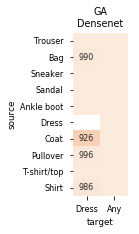

In [196]:
plt.gcf().set_size_inches(1, 3)
mask = np.zeros(shape=(10, 2), dtype=np.bool)
mask[5, 0] = True
sns.set_context('paper')
g = sns.heatmap(
    data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False,
    annot=np.where(heatmap.values == 1000, '', heatmap),
    annot_kws={'size': 8}, mask=mask
)
g.set_title('GA\n{tt}'.format(
    tt=architecture.capitalize()
))

exp_name = 'ea_{}'.format(architecture)

plt.gcf().savefig(
    'thesis/img/{}_cm.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

In [199]:
df['label'] = dataset.metadata['synset'][df['label']]
df['steps'] = 256 * df.steps

plt.gcf().set_size_inches(4, 3)
for target in ['non_targeted', 'targeted_3']:
    sns.set_context('paper')
    
    if target == 'targeted_3':
        order = [
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
        ]
    else:
        order = [
            'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
            'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
        ]
    
    g = sns.boxplot(order=order, data=df[df.target == target], x='label', y='steps', hue='architecture', showfliers=False, linewidth=1)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.legend(loc='upper center')
    
    if target == 'non_targeted':
        g.set_title('Non targeted')
    else:
        g.set_title(dataset.metadata['synset'][int(target[-1])])


    exp_name = 'ga_{}'.format(target)
    plt.gcf().savefig(
        'thesis/img/{}.pdf'.format(exp_name),
        dpi=300, format='pdf', bbox_inches='tight'
    )
    plt.clf()

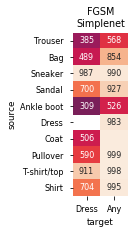

In [143]:
target_class = 3
dir_name = 'experiments/fgsm/full_surrogate/{tt}/single/{st}'

surrogate_architecture = 'simplenet'
target_architecture = 'simplenet'

plt.gcf().set_size_inches(1, 3)
dfs = []
for target in ['targeted_{}'.format(target_class), 'non_targeted']:
    df = experiment_to_df(
        dir_name.format(tt=target_architecture, st=surrogate_architecture), target,
        dataset.test,
        use_cached=False
    )
    df['target'] = target
    dfs.append(df)

df = pd.concat(dfs)

heatmap = df.pivot_table(
    values='steps', index='label', columns='target', aggfunc=len, fill_value=0
)
heatmap = heatmap.rename(
    index={i: dataset.metadata['synset'][i] for i in range(10)},
    columns={**{'targeted_{}'.format(i): dataset.metadata['synset'][i] for i in range(10)}, **{'non_targeted': 'Any'}}
)

heatmap = heatmap[[dataset.metadata['synset'][target_class], 'Any']]
heatmap = heatmap.reindex(index=[
    'Trouser', 'Bag', 'Sneaker', 'Sandal', 'Ankle boot',
    'Dress', 'Coat', 'Pullover', 'T-shirt/top', 'Shirt'
], fill_value=0)
heatmap.index.rename('source', inplace=True)

mask = np.zeros(shape=(10, 2), dtype=np.bool)
mask[5, 0] = True
# mask[:, 1] = True
# mask[5, 1] = False
sns.set_context('paper')
g = sns.heatmap(
    data=heatmap, vmin=0, vmax=1000, fmt='', cbar=False,
    annot=np.where(heatmap.values == 1000, '', heatmap),
    annot_kws={'size': 8}, mask=mask
)
g.set_title('FGSM\n{tt}'.format(
    tt=target_architecture.capitalize()
))

exp_name = dir_name.format(tt=target_architecture, st=surrogate_architecture).replace('/', '_')

plt.gcf().savefig(
    'thesis/img/dress_{}_cm.pdf'.format(exp_name),
    dpi=300, format='pdf', bbox_inches='tight'
)

### Surrogate FGSM ###

In [50]:
# exp_path = 'fgsm_direct_single_targeted'
target = 3
results = {}
# for target in range(10):
    # for architecture in ['simplenet', 'densenet']:
valids = []
step_counts = []
mses = []

for f_i in range(10):
    with np.load(
        # 'experiments/{p}/{t}/{a}_{f}_fgsm_direct_single_targeted_{t}.npz'.format(
        #     p=exp_path, t=target, a=architecture, f=f_i
        # )
        'experiments/simplenet_simplenet_{}_fgsm_reduced_surrogate_single_targeted_{}.npz'.format(
            f_i, target
        )
    ) as exp_f:
        step_count = exp_f['step_count']
        valid_mask = (step_count != -1)
        step_count[~valid_mask] = -1

        mse = np.mean(255 * np.abs(exp_f['noise']), axis=(1, 2, 3))
        mse[~valid_mask] = np.NaN

        valids.append(valid_mask)
        step_counts.append(step_count)
        mses.append(mse)

valids = np.array(valids).transpose()
step_counts = np.array(step_counts).transpose()
mses = np.array(mses).transpose()

pd.DataFrame(
    data={
        'label': dataset.test.y[dataset.test.y != target],
        'success': np.all(valids, axis=-1),
        'median_steps': np.median(step_counts, axis=-1),
        'mean_steps': np.mean(step_counts, axis=-1),
        'median_mse': np.median(mses, axis=-1),
        'mean_mse': np.mean(mses, axis=-1)
    },
    index=dataset.test.id[dataset.test.y != target]
).to_csv('experiments/reduced_test.csv')

/home/proste/mff/evgena/env_evgena/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 7139 results
  r = func(a, **kwargs)


In [51]:
df = pd.read_csv('experiments/reduced_test.csv')

In [52]:
df[df['success']].describe()

,Unnamed: 0,label,median_steps,mean_steps,median_mse,mean_mse
count,1.861000e+03,1861.000000,1861.000000,1861.000000,1861.000000,1861.000000
mean,-1.630161e+16,4.564750,19.677593,22.582214,12.410178,12.607053
std,5.262171e+18,2.805088,8.944259,11.909192,4.362029,4.363475
min,-9.216800e+18,0.000000,0.000000,0.000000,1.000000,0.999872
25%,-4.523253e+18,2.000000,14.500000,15.300000,10.160714,10.434949
50%,-2.598184e+16,5.000000,21.000000,22.200000,13.426020,13.693176
75%,4.568241e+18,7.000000,24.500000,28.600000,15.650511,15.818942
max,9.212468e+18,9.000000,71.500000,83.500000,20.527424,20.082462


In [163]:
step_stats = {'step_count': [], 'mean': [], 'median': [], 'p95': []}
noise_stats = {'mean_shade': [], 'mean': [], 'median': [], 'p95': []}
fails = []

target_architecture = 'simple'
surrogate_architecture = 'simple'
l_i = None

# for f_i in range(10):
for f_i in range(1):
    with np.load(
        'experiments/{sa}_{ta}_{f}_fgsm_full_surrogate_single_{t}.npz'.format(
            sa=surrogate_architecture, ta=target_architecture, f=f_i,
            t='non_targeted' if l_i is None else 'targeted_{}'.format(l_i)
        )
    ) as exp_f:
        step_count = exp_f['step_count']
        valid_mask = step_count >= 0
        
        fails.append(np.where(~valid_mask)[0])
        
        step_count = step_count[valid_mask]
        step_stats['step_count'].append(step_count)
        step_stats['mean'].append(np.mean(step_count))
        step_stats['median'].append(np.median(step_count))
        step_stats['p95'].append(np.percentile(step_count, 95))

        noise_steps = np.mean(255 * np.abs(exp_f['noise'][valid_mask]), axis=(1, 2, 3))
        noise_stats['mean_shade'].append(noise_steps)
        noise_stats['mean'].append(np.mean(noise_steps))
        noise_stats['median'].append(np.median(noise_steps))
        noise_stats['p95'].append(np.percentile(noise_steps, 95))

## Target model trainings ##

In [30]:
result = {}
for model_type, metric in [(t, m) for t in ['simplenet', 'densenet'] for m in ['loss', 'acc']]:
    metrics = []
    for f_i in range(10):
        with open(
            'experiments/fashion_mnist_{}_fold_{}_val_{}.csv'.format(model_type, f_i, metric), 'r'
        ) as loss_f:
            metrics.append(np.array([float(line.rstrip().split(',')[-1]) for l_i, line in enumerate(loss_f) if l_i != 0]))
    
    metrics = np.array(metrics)
    result['_'.join((model_type, metric))] = metrics

/home/proste/mff/evgena/env_evgena/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


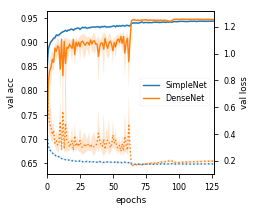

In [106]:
fig, ax = plt.subplots(figsize=(3,3))
ax2 = ax.twinx()
cp = sns.color_palette()
sns.tsplot(
    condition=['SimpleNet', 'DenseNet'], legend=True, ax=ax, value='val acc',
    data=np.stack((result['simplenet_acc'], result['densenet_acc']), axis=-1), ci=95)
sns.tsplot(
    condition=['SimpleNet', 'DenseNet'], legend=False, linestyle=':', ax=ax2, value='val loss',
    data=np.stack((result['simplenet_loss'], result['densenet_loss']), axis=-1), ci=95)

ax.legend(loc='center right')
ax.set_xlabel('epochs')

fig.savefig('thesis/img/training.pdf', dpi=300, format='pdf', bbox_inches='tight')